# Ipynb to 

* try out different ML fits with the package `Graphlab`.

### Note
The train data was created using `createGraphlabTrainSet.ipynb`


A partir de las 3 tablas ya procesdas : 
* homeantennas
* sumlinks
* groundtruth

armames un datset para explorar conceptos de ML

In [1]:
## seteamos los parametros del notebook
%autosave 180
import pandas as pd; 
import os;
import random;
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np; 

from IPython.display import display # para pretty-print con estetica ipython si es que estamos dentro de  un loop, if, etc

import graphlab as gl
#esto es para dibujar directo a la notebook
gl.canvas.set_target('ipynb')

# for nice graphics and plots
import seaborn as sns
palette = sns.color_palette()

# for nice long graphic titles
from textwrap import wrap

#seteamos el lugar de trabajo
HOMEDIR=os.path.expanduser('~')
PROJECTDIR = os.getcwd().split(os.sep)
PROJECTDIR =  os.sep.join(PROJECTDIR[:PROJECTDIR.index('mexico-scripts-ver2') + 1])

DATADIR = os.path.join(PROJECTDIR,'datasets')
# os.chdir(DATADIR)


Autosaving every 180 seconds
This non-commercial license of GraphLab Create for academic use is assigned to jdemonasterio@dc.uba.ar and will expire on May 06, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1505492757.log


In [2]:
## set our plotting style
plt.style.use('seaborn-paper')

In [3]:
!ls $DATADIR

data_balanced_sample.csv  gtruth_0215_0715  sl	       train_set
gtruth_0114_0715	  homeant	    sl.csv.gz  tree.dot


In [4]:
graphlab_frame = True
# graphlab_frame = 'juan' in HOMEDIR

input_binary_path = DATADIR +"/train_set"


## decide if load a reduced size dataset

In [5]:
# set what is the resulting sample we want of the global dataset
seed = 2015
sample_val = 0.25
# sample_val = None

In [6]:
!ls $DATADIR

data_balanced_sample.csv  gtruth_0215_0715  sl	       train_set
gtruth_0114_0715	  homeant	    sl.csv.gz  tree.dot


In [7]:
%%time
data = gl.load_sframe(input_binary_path)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.7 ms


In [8]:
if sample_val:
    data, _ = data.random_split(sample_val,seed=seed)


print(data.shape)

(370857, 176)


## view column names

In [9]:
data.column_names

<bound method SFrame.column_names of Columns:
	USER	str
	TimeWeekEnd_OUT_12	int
	CallsWeekDay_OUT_12	int
	CallsWeekNight_OUT_12	int
	TimeWeekDay_OUT_12	int
	CallsWeekEnd_OUT_12	int
	TimeWeekNight_OUT_12	int
	TimeWeekEnd_OUT_VUL_12	int
	CallsWeekDay_OUT_VUL_12	int
	CallsWeekNight_OUT_VUL_12	int
	TimeWeekDay_OUT_VUL_12	int
	CallsWeekEnd_OUT_VUL_12	int
	TimeWeekNight_OUT_VUL_12	int
	VULNERABLE_OUT_12	int
	TimeWeekEnd_IN_12	int
	CallsWeekDay_IN_12	int
	CallsWeekNight_IN_12	int
	TimeWeekDay_IN_12	int
	CallsWeekEnd_IN_12	int
	TimeWeekNight_IN_12	int
	TimeWeekEnd_IN_VUL_12	int
	CallsWeekDay_IN_VUL_12	int
	CallsWeekNight_IN_VUL_12	int
	TimeWeekDay_IN_VUL_12	int
	CallsWeekEnd_IN_VUL_12	int
	TimeWeekNight_IN_VUL_12	int
	VULNERABLE_IN_12	int
	TimeWeekEnd_OUT_08	int
	CallsWeekDay_OUT_08	int
	CallsWeekNight_OUT_08	int
	TimeWeekDay_OUT_08	int
	CallsWeekEnd_OUT_08	int
	TimeWeekNight_OUT_08	int
	TimeWeekEnd_OUT_VUL_08	int
	CallsWeekDay_OUT_VUL_08	int
	CallsWeekNight_OUT_VUL_08	int
	TimeWeekDay_OUT_VUL

# For column descriptions please see `createGraphlabTrainSet.ipynb`

### minor analytics

In [10]:
data['EPIDEMIC_gt'].sum(),data['EPIDEMIC'].sum()

(101433, 100389)

In [11]:
data.shape

(370857, 176)

## Preparamos los datasets que no pueden tomar valores negativos o categorical vars

# train test split as 
p% of set as validation and the resulting  as train

In [12]:
split_perc = 0.9
data, test_set = data.random_split(sample_val,seed=seed)

## define our real  variable and Y vars

exclude/include features. Decide our problem (multi-target, single_target)

## in our   features..

determine which columns have no meaning.

we are going to try different models

In [13]:
iterable=data.column_names()

# this param will *force* the exclusion of these columns in the final X_train, no matter what.

manual_exclude_cols = [     
#     'EPIDEMIC',
     'EPIDEMIC_gt', # thinking of the argentina dataset, this variable is *always* missing
#       'STATE',
                ]

comprehensive_exclude_cols = [col for col in iterable if col == 'USER' 
          or ('ANTENNA' in col) ]   
                                
exclude_cols = manual_exclude_cols + comprehensive_exclude_cols
exclude_cols

['EPIDEMIC_gt',
 'USER',
 'ANTENNA_ID_0',
 'ANTENNA_ID_1',
 'ANTENNA_ID_2',
 'ANTENNA_ID_3',
 'ANTENNA_ID_4',
 'ANTENNA_ID_5',
 'ANTENNA_ID_6',
 'ANTENNA_ID_7',
 'ANTENNA_ID_8',
 'ANTENNA_ID_9',
 'ANTENNA_ID_WEEKNIGHT_0',
 'ANTENNA_ID_WEEKNIGHT_1',
 'ANTENNA_ID_WEEKNIGHT_2',
 'ANTENNA_ID_WEEKNIGHT_3',
 'ANTENNA_ID_WEEKNIGHT_4',
 'ANTENNA_ID_WEEKNIGHT_5',
 'ANTENNA_ID_WEEKNIGHT_6',
 'ANTENNA_ID_WEEKNIGHT_7',
 'ANTENNA_ID_WEEKNIGHT_8',
 'ANTENNA_ID_WEEKNIGHT_9']

## first our Y vars

define them with a set of different possible CASEs/problems to solve

In [14]:
CASE = 3

## people that used to live in the endemic area
if CASE ==0:
    CASE_TEXT = "people that used to live in the endemic area"
    
    Y_train =  data['EPIDEMIC_gt'] == 1
    Y_test = test_set['EPIDEMIC_gt'] == 1
    add_exclusion_cols =[     
            #     'EPIDEMIC',
#                  'EPIDEMIC_gt',
#                   'STATE',
                ]

## people that used to live in the endemic area *and* migrated
if CASE ==1:
    CASE_TEXT = "people that used to live in the endemic area *and* migrated"
    Y_train =  (data['EPIDEMIC_gt'] ==1) & (data['EPIDEMIC'] ==0)
    Y_test = (test_set['EPIDEMIC_gt'] ==1) & (test_set['EPIDEMIC'] ==0)
    add_exclusion_cols = [
#                         'EPIDEMIC',
                          'STATE',
#                          'EPIDEMIC_gt',
                    ]

##  people that migrated in any direction
if CASE ==2:
    CASE_TEXT = "people that migrated in any direction"
    Y_train =  data['EPIDEMIC_gt'] != data['EPIDEMIC']
    Y_test = test_set['EPIDEMIC_gt'] != test_set['EPIDEMIC']
    
    add_exclusion_cols = [           
#                  'EPIDEMIC',
#                    'STATE',
]

    
##  people that migrated in any direction, but are currently non-endemic
if CASE ==3:
    CASE_TEXT = "currently non_endemic, that used to live in the endemic area"
    
    data = data[data['EPIDEMIC'] ==0]
    test_set = test_set[test_set['EPIDEMIC'] ==0]

    Y_train =  (data['EPIDEMIC_gt'] ==1)
    Y_test = (test_set['EPIDEMIC_gt'] ==1) 
    
    add_exclusion_cols = [
                'EPIDEMIC'
#                 'EPIDEMIC_gt',
                'STATE',
         
                         ]    
    
## people from the Mexico or DF states
if CASE == 4:
    CASE_TEXT = "people from the Mexico or DF states"
    Y_train =  (data['STATE'] == 'Distrito_Federal') | (data['STATE'] == 'Mexico')
    Y_test = (test_set['STATE'] == 'Distrito_Federal') | (test_set['STATE'] == 'Mexico')
    
    add_exclusion_cols = [
                'EPIDEMIC',
                'STATE',
                ]
                        
## people with a HIGH present mobility (>1000 after looking at percentiles of the MOBILITY_DIAMTER)
if CASE == 5:
    val = 1000
    CASE_TEXT = "people with a high mobility during present time (values > {} )".format(val)
    Y_train =  (data['MOBILITY_DIAMETER'] > val) 
    Y_test = (test_set['MOBILITY_DIAMETER'] > val) 
    
    add_exclusion_cols = [
        
        'MOBILITY_DIAMETER_WEEKNIGHT',
        'MOBILITY_DIAMETER',
    ]

for col in add_exclusion_cols:
    if not col in exclude_cols:
        exclude_cols+=[col]

In [15]:
add_exclusion_cols, exclude_cols

(['EPIDEMICSTATE'],
 ['EPIDEMIC_gt',
  'USER',
  'ANTENNA_ID_0',
  'ANTENNA_ID_1',
  'ANTENNA_ID_2',
  'ANTENNA_ID_3',
  'ANTENNA_ID_4',
  'ANTENNA_ID_5',
  'ANTENNA_ID_6',
  'ANTENNA_ID_7',
  'ANTENNA_ID_8',
  'ANTENNA_ID_9',
  'ANTENNA_ID_WEEKNIGHT_0',
  'ANTENNA_ID_WEEKNIGHT_1',
  'ANTENNA_ID_WEEKNIGHT_2',
  'ANTENNA_ID_WEEKNIGHT_3',
  'ANTENNA_ID_WEEKNIGHT_4',
  'ANTENNA_ID_WEEKNIGHT_5',
  'ANTENNA_ID_WEEKNIGHT_6',
  'ANTENNA_ID_WEEKNIGHT_7',
  'ANTENNA_ID_WEEKNIGHT_8',
  'ANTENNA_ID_WEEKNIGHT_9',
  'EPIDEMICSTATE'])

In [16]:
iterable=data.column_names()

width = 30
N= pd.np.random.randint(1,int(len(iterable)*1.0/width))
data.column_names()[(N)*width: (N+1)*width]

['TimeWeekNight_OUT_VUL_10',
 'VULNERABLE_OUT_10',
 'TimeWeekEnd_IN_10',
 'CallsWeekDay_IN_10',
 'CallsWeekNight_IN_10',
 'TimeWeekDay_IN_10',
 'CallsWeekEnd_IN_10',
 'TimeWeekNight_IN_10',
 'TimeWeekEnd_IN_VUL_10',
 'CallsWeekDay_IN_VUL_10',
 'CallsWeekNight_IN_VUL_10',
 'TimeWeekDay_IN_VUL_10',
 'CallsWeekEnd_IN_VUL_10',
 'TimeWeekNight_IN_VUL_10',
 'VULNERABLE_IN_10',
 'TimeWeekEnd_OUT_11',
 'CallsWeekDay_OUT_11',
 'CallsWeekNight_OUT_11',
 'TimeWeekDay_OUT_11',
 'CallsWeekEnd_OUT_11',
 'TimeWeekNight_OUT_11',
 'TimeWeekEnd_OUT_VUL_11',
 'CallsWeekDay_OUT_VUL_11',
 'CallsWeekNight_OUT_VUL_11',
 'TimeWeekDay_OUT_VUL_11',
 'CallsWeekEnd_OUT_VUL_11',
 'TimeWeekNight_OUT_VUL_11',
 'VULNERABLE_OUT_11',
 'TimeWeekEnd_IN_11',
 'CallsWeekDay_IN_11']

In [17]:
%%time

X_train = data[[col for col in iterable if col not in exclude_cols]]

CASE_TEXT += '. Excluding features: '
for col in exclude_cols:
    CASE_TEXT+= col +', '

X_test = test_set[[col for col in iterable if col not in exclude_cols]]   

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.5 ms


In [18]:
# clean negative/Null vals in count cols 
iterable=X_train.column_names()
for col in [col for col in iterable if 'COUNT' in col]:
    X_train[col]= X_train[col].apply(lambda x :  x if x>=0 else 0)
    X_test[col]= X_test[col].apply(lambda x :  x if x>=0 else 0)

In [19]:
X_train.shape, Y_train.shape

((67419, 154), (67419,))

## dummy-ize categorical cols
if necessary

In [20]:
iterable=X_train.column_names()

categorical_cols = [
    'STATE'
]

In [21]:
from graphlab.toolkits.feature_engineering import OneHotEncoder
# learn encodings from all categorical cols in the train set
encoder = gl.feature_engineering.create(data[categorical_cols], OneHotEncoder())

In [22]:
categorical_cols

['STATE']

In [23]:
# check existence of categorical cols in our X_train 
categorical_train_cols = [col for col in categorical_cols if  col not in exclude_cols]
categorical_train_cols

['STATE']

In [24]:
if categorical_train_cols:
    print('dummy encoding')
    # fit on X_train and transform both test and train
    X_train[categorical_train_cols] = encoder.fit_transform(X_train[categorical_train_cols])
    X_test[categorical_train_cols] = encoder.transform(X_test[categorical_train_cols])
    

dummy encoding


In [25]:
X_train.head()

TimeWeekEnd_OUT_12,CallsWeekDay_OUT_12,CallsWeekNight_OUT_12,TimeWeekDay_OUT_12,CallsWeekEnd_OUT_12,TimeWeekNight_OUT_12
219,7,2,348,5,168
78,2,0,79,1,0
3359,42,82,4779,40,20569
966,88,29,11991,10,2313
0,20,0,1017,0,0
632,26,11,1613,8,637
0,0,3,0,0,607
3307,49,14,3448,42,558
375,14,2,1388,3,76
804,40,7,7554,12,757


### our new encoded column is added, we must now remove the old str columns

In [26]:
if categorical_train_cols:
    X_train = X_train.remove_columns(categorical_train_cols)
    X_test = X_test.remove_columns(categorical_train_cols)

In [27]:
# for col in categorical_cols:
    
#     if col not in exclude_cols:
#         print('we are categorizing col %s' %col)
        
#         X_train[col] = X_train[col].astype('category')
#     #     if X_train[col].dtype != 'category':
#     #         continue 
#         X_train = pd.concat([_train,pd.get_dummies(X_train[col], 
#                                           prefix= col, 
#                                           prefix_sep='_', 
#                                           #sparse = True,
#                                           dummy_na=False).astype(pd.np.int8)],\
#                   axis=1 ,join = 'inner')
#         X_train.drop(col, axis =1 , inplace=True)

#         # now onto test_table
#         X_test[col] = X_test[col].astype('category')
#         X_test = pd.concat([_test,pd.get_dummies(X_test[col], 
#                                           prefix= col, 
#                                           prefix_sep='_', 
#                                           #sparse = True,
#                                           dummy_na=False).astype(pd.np.int8)],\
#                   axis=1 ,join = 'inner')

#         X_test.drop(col, axis =1 , inplace=True)


## explore correlations to target var

with current column configuration

In [28]:
do_correlation = False
if do_correlation:
    corr = X_train.to_dataframe().copy()
    target_col = 'target'
    corr[target_col] = Y_train
    corr = corr.corr()
    print(corr.shape)

In [29]:
if do_correlation:
    view = corr.query('target>0.1')
    # show only those columns which 
    corr_columns = view.index.values

    display(view[corr_columns].head(10))

In [30]:
## show correlation between state and target
if do_correlation:
    if not 'STATE' in exclude_cols:    
        state_cols = [col for col in corr if 'STATE' in col]
        view = corr[state_cols + [target_col]]
        display(view.query('target > 0.01'))


## class weight check

In [31]:
a=Y_train.sum();b= Y_train.shape[0]
a*1.0/b

0.019475222118393924

# get metric functions and sklearn model selectors

In [32]:
from sklearn.metrics import *
# from sklearn.cross_validation import *
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     train_test_split, KFold, cross_val_predict, 
                                     cross_val_score, learning_curve, validation_curve
                                    )

## define a general cv procedure calling function
with time, results, scores and output strings.

In [33]:

def fit_cv_procedure(clf_object,X_train,Y_train,
                     scoring, param_grid, num_jobs, 
                     **kw):
    rv = {}
    out_str = ""
    error_str = ""
    start_time = time.time()
    
    clf =GridSearchCV( clf_object, 
                      param_grid, 
                      scoring=scoring, 
                      n_jobs=num_jobs, 
                      **kw
                      )

    try:
        
        clf.fit(X_train, Y_train)
        
        grid_time =   time.time() - start_time 
    
        out_str+='HyperParam Search took {} seconds to run'.format(grid_time)

        cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, 
                                value in clf.grid_scores_[0].parameters.items() ] )

        for i, setup in enumerate(clf.grid_scores_):
            row = [clf.grid_scores_[i].mean_validation_score ] + [value for key,
                                                value in clf.grid_scores_[i].parameters.items() ]
            cv_result.loc[i] = row
        
        rv['cv_result'] = cv_result
        rv['grid_time'] = grid_time

    except Exception as e:
        error_str = str(e)
    
    #este flag es basicamente para chequear que hayamos terminado nomas
    rv['clf'] = clf
    rv['out_str'] = out_str
    rv['error_str'] = error_str
    
    return rv

## define test scoring fun for the resulting cv proced

In [34]:
def score_on_test_data(res_cv, 
                      X_test,
                      Y_test,
                      scoring):
    
    # init score str
    score_str = ''
    if res_cv['error_str']:
      return  
    
    if not res_cv['error_str']: # we enrich the res_cv object
        grid_time = res_cv['grid_time']
        # get fitted classifier
        clf = res_cv['clf']
#         print(grid_time)
        
        # get best estimator hyperparam values
        score_str+='\n Best estimator was {!s} \n'.format(clf.best_estimator_)
        score_str+='\n Best estimator\'s score was {:.3f} in "{}" \n'.format( clf.best_score_,
                                                            scoring)

        ## get testing score with the score used inour function
        scoring_fun = SCORERS[scoring]
        # get score for test data
        test_score = scoring_fun(clf,X_test,Y_test)

        score_str+='\nBest estimator\'s performance with \
"{}" metric on the test set is: {:.3f}\n'.format( scoring,
                                                         test_score,
                                                        )

        score_str+='\nParam exploration Search took {} seconds to run'.format(grid_time)
        score_str+='\nOur problem type id is {} which means \"{}\"'.format(CASE,CASE_TEXT.capitalize())
        res_cv['test_score'] = test_score
        
    res_cv['score_str'] = score_str
    
    return res_cv

## init graphlab models 

In [35]:
from graphlab import random_forest_classifier, boosted_trees_classifier, logistic_classifier, decision_tree_classifier
from graphlab.toolkits import cross_validation, model_parameter_search

# get kfolds

In [36]:
%%time
num_folds = 8

target_col = 'target'

X_train[target_col] = Y_train
X_test[target_col] = Y_test
kfold = cross_validation.KFold(
        X_train,num_folds=num_folds)


CPU times: user 1.12 s, sys: 192 ms, total: 1.31 s
Wall time: 426 ms


## RandomForest 
HyperParams Grid Search

In [37]:

param_grid = {
    "target":target_col,
#     'validation_accuracy': 'auc',
#         'training_accuracy': 'auc',
    'metric': [
                'auc',
                'f1',
#                 'accuracy',
        
                 ], 
    
    'max_iterations': [
#                     50,
                    100,
                    150,
                    200,
                    ],
    
  'column_subsample': [
                  pd.np.sqrt(X_train.shape[1])/X_train.shape[1],
                  0.5,
                  0.95,
                  ], 
    
    "row_subsample": [ 
                    pd.np.sqrt(X_train.shape[0])/X_train.shape[0],
                  0.95,
                    ],
#     "min_child_weight": pd.np.random.randint(3,15,3),
    'max_depth':[
                3,
                 6,
                 9,
                ], 
   "class_weights": [
                   'auto',
#                    None,
                   ],
    "validation_set": [X_test],
              }

model_factory = random_forest_classifier.create

In [38]:
# random_forest_classifier??

In [39]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, test_set],
                                             model_factory = model_factory,
                                            model_parameters = param_grid, 
                                             perform_trial_run = True,
                                            )

search_results = model_search.get_results()

all_time = time.time() - start_time

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Sep-15-2017-16-26-2600000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Sep-15-2017-16-26-2600000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Sep-15-2017-16-26-2600000' already exists. Renaming the job to 'Model-Parameter-Search-Sep-15-2017-16-26-2600000-f558d'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Sep-15-2017-16-26-2600000-f558d' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Sep-15-2017-16-26-2600000-f558d' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Sep-15-2017-16-26-2600001' ready for execution


CPU times: user 45.1 s, sys: 6.1 s, total: 51.2 s
Wall time: 9min 26s


In [40]:
# hours,minutes
int(abs(all_time)/3600) ,(abs(all_time)/3600 %1)*60

(0, 9.440886382261912)

In [41]:
res = model_search.get_metrics()
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-09-15 16:27:03,16.1147449017,None,None,None
_train_test_model-0-1,Completed,2017-09-15 16:27:19,10.9961009026,None,None,None
_train_test_model-0-2,Completed,2017-09-15 16:27:31,10.6601471901,None,None,None
_train_test_model-0-3,Completed,2017-09-15 16:27:42,10.4266269207,None,None,None
_train_test_model-0-4,Completed,2017-09-15 16:27:52,17.9068341255,None,None,None
_train_test_model-0-5,Completed,2017-09-15 16:28:10,9.97759199142,None,None,None
_train_test_model-0-6,Completed,2017-09-15 16:28:20,9.73717403412,None,None,None
_train_test_model-0-7,Completed,2017-09-15 16:28:30,9.44384908676,None,None,None
_train_test_model-0-8,Completed,2017-09-15 16:28:39,14.8451268673,None,None,None
_train_test_model-0-9,Completed,2017-09-15 16:28:54,8.79217195511,None,None,None


In [42]:
search_results.shape

(10, 14)

In [43]:
search_results.column_names()

['class_weights',
 'column_subsample',
 'max_depth',
 'max_iterations',
 'metric',
 'min_child_weight',
 'min_loss_reduction',
 'row_subsample',
 'target',
 'num_folds',
 'fold_id',
 'mean_training_accuracy',
 'mean_validation_accuracy',
 'model_id']

In [44]:
search_results

class_weights,column_subsample,max_depth,max_iterations,metric,min_child_weight,min_loss_reduction
auto,0.0803219328902,9,100,auc,1,10
auto,0.95,3,150,f1,2,0
auto,0.95,3,100,auc,16,1
auto,0.5,9,150,f1,16,10
auto,0.0803219328902,3,150,auc,1,10
auto,0.5,6,200,f1,8,0
auto,0.0803219328902,3,100,f1,2,1
auto,0.0803219328902,3,150,f1,8,1
auto,0.0803219328902,9,100,auc,16,1
auto,0.5,9,200,f1,8,1


In [45]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy'),
                                'mean_val':gl.aggregate.MEAN('mean_validation_accuracy'),
                                'std_val':gl.aggregate.STD('mean_validation_accuracy')
                              }
                                )
         )

+---------------+----------------+----------------+----------------+
| class_weights |      std       |    mean_val    |    std_val     |
+---------------+----------------+----------------+----------------+
|      auto     | 0.393385302867 | 0.620937175931 | 0.394109714649 |
+---------------+----------------+----------------+----------------+
+----------------+
|      mean      |
+----------------+
| 0.619856148212 |
+----------------+
[1 rows x 5 columns]

+------------------+-----------------+----------------+-----------------+
| column_subsample |       std       |    mean_val    |     std_val     |
+------------------+-----------------+----------------+-----------------+
| 0.0803219328902  | 0.0168231580573 | 0.883280988491 | 0.0214841171431 |
|       0.5        |  0.402443810775 | 0.305087346465 |  0.403917161059 |
|       0.95       |  0.412911429419 | 0.438852388733 |  0.41937760589  |
+------------------+-----------------+----------------+-----------------+
+----------------+
|

### Refit best model for feature importance

In [46]:
CASE, CASE_TEXT

(3,
 'currently non_endemic, that used to live in the endemic area. Excluding features: EPIDEMIC_gt, USER, ANTENNA_ID_0, ANTENNA_ID_1, ANTENNA_ID_2, ANTENNA_ID_3, ANTENNA_ID_4, ANTENNA_ID_5, ANTENNA_ID_6, ANTENNA_ID_7, ANTENNA_ID_8, ANTENNA_ID_9, ANTENNA_ID_WEEKNIGHT_0, ANTENNA_ID_WEEKNIGHT_1, ANTENNA_ID_WEEKNIGHT_2, ANTENNA_ID_WEEKNIGHT_3, ANTENNA_ID_WEEKNIGHT_4, ANTENNA_ID_WEEKNIGHT_5, ANTENNA_ID_WEEKNIGHT_6, ANTENNA_ID_WEEKNIGHT_7, ANTENNA_ID_WEEKNIGHT_8, ANTENNA_ID_WEEKNIGHT_9, EPIDEMICSTATE, ')

In [47]:
params = model_search.get_best_params()

In [48]:
params

{'class_weights': 'auto',
 'column_subsample': 0.080321932890249886,
 'max_depth': 3,
 'max_iterations': 100,
 'metric': 'f1',
 'min_child_weight': 2,
 'min_loss_reduction': 1,
 'row_subsample': 0.95,
 'target': 'target',
 'validation_set': Columns:
 	TimeWeekEnd_OUT_12	int
 	CallsWeekDay_OUT_12	int
 	CallsWeekNight_OUT_12	int
 	TimeWeekDay_OUT_12	int
 	CallsWeekEnd_OUT_12	int
 	TimeWeekNight_OUT_12	int
 	TimeWeekEnd_OUT_VUL_12	int
 	CallsWeekDay_OUT_VUL_12	int
 	CallsWeekNight_OUT_VUL_12	int
 	TimeWeekDay_OUT_VUL_12	int
 	CallsWeekEnd_OUT_VUL_12	int
 	TimeWeekNight_OUT_VUL_12	int
 	VULNERABLE_OUT_12	int
 	TimeWeekEnd_IN_12	int
 	CallsWeekDay_IN_12	int
 	CallsWeekNight_IN_12	int
 	TimeWeekDay_IN_12	int
 	CallsWeekEnd_IN_12	int
 	TimeWeekNight_IN_12	int
 	TimeWeekEnd_IN_VUL_12	int
 	CallsWeekDay_IN_VUL_12	int
 	CallsWeekNight_IN_VUL_12	int
 	TimeWeekDay_IN_VUL_12	int
 	CallsWeekEnd_IN_VUL_12	int
 	TimeWeekNight_IN_VUL_12	int
 	VULNERABLE_IN_12	int
 	TimeWeekEnd_OUT_08	int
 	CallsWeekDay

In [49]:
# ## manually insert params if needed
manual_params = False
if manual_params:
    params = {'class_weights': 'auto',
 'column_subsample': 0.6,
 'max_depth': 6,
 'max_iterations': 100,
 'metric': 'f1',
 'min_child_weight': 1,
 'min_loss_reduction': 1,
 'row_subsample': 0.95,
 'target': 'target'}
print(manual_params)

False


In [50]:
%%time
best_model =  random_forest_classifier.create(dataset=X_train,
#                                              validation_set = X_test,
                                             **params)

WARNING: Detected extremely low variance for feature(s) 'EPIDEMIC' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

WARNING: Ignore unsupported tracking metric f1

Random forest classifier:

--------------------------------------------------------

Number of examples          : 67419

Number of classes           : 2

Number of feature columns   : 154

Number of unpacked features : 177

+-----------+--------------+

| Iteration | Elapsed Time |

+-----------+--------------+

| 1         | 0.585857     |

| 2         | 0.635543     |

| 3         | 0.682141     |

| 4         | 0.730413     |

| 5         | 0.786914     |

| 6         | 0.838181     |

| 11        | 1.091128     |

| 25        | 1.786366     |

| 50        | 3.020162     |

| 51        | 3.067948     |

| 75        | 4.228798     |

| 100       | 5.458908     |

+-----------+--------------+

CPU times: user 58.4 s, sys: 1.01 s, total: 59.4 s
Wall time: 8.63 s


In [51]:
best_feat = best_model.get_feature_importance()
best_feat.head(20)

name,index,count
CallsWeekDay_IN_08,None,26
MOBILITY_DIAMETER,None,23
CallsWeekDay_IN_09,None,22
CallsWeekDay_IN_10,None,20
TimeWeekDay_IN_VUL_09,None,20
CallsWeekDay_OUT_09,None,20
MOBILITY_DIAMETER_WEEKNIGHT ...,None,19
TimeWeekDay_IN_08,None,18
TimeWeekDay_IN_09,None,15
TimeWeekDay_OUT_VUL_11,None,14


In [52]:
list(best_feat['name'].head(20))
#print_rows(num_rows= 30)

['CallsWeekDay_IN_08',
 'MOBILITY_DIAMETER',
 'CallsWeekDay_IN_09',
 'CallsWeekDay_IN_10',
 'TimeWeekDay_IN_VUL_09',
 'CallsWeekDay_OUT_09',
 'MOBILITY_DIAMETER_WEEKNIGHT',
 'TimeWeekDay_IN_08',
 'TimeWeekDay_IN_09',
 'TimeWeekDay_OUT_VUL_11',
 'COUNT_0',
 'VULNERABLE_IN_12',
 'CallsWeekDay_OUT_10',
 'CallsWeekEnd_OUT_VUL_08',
 'TimeWeekDay_OUT_10',
 'VULNERABLE_IN_11',
 'VULNERABLE_OUT_11',
 'TimeWeekEnd_IN_08',
 'VULNERABLE_IN_08',
 'CallsWeekDay_OUT_08']

In [53]:
best_model.training_time

5.4596

In [55]:
test_error = best_model.evaluate(X_test)

test_error

{'accuracy': 0.8987141034922604,
 'auc': 0.8530779006267356,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+--------+
 | target_label | predicted_label | count  |
 +--------------+-----------------+--------+
 |      1       |        0        |  1345  |
 |      1       |        1        |  2631  |
 |      0       |        1        | 19221  |
 |      0       |        0        | 179852 |
 +--------------+-----------------+--------+
 [4 rows x 3 columns],
 'f1_score': 0.20373238345981107,
 'log_loss': 0.47432730422415664,
 'precision': 0.12040087863811093,
 'recall': 0.6617203219315896,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+--------+
 | threshold | fpr | tpr |  p   |   n    |
 +-----------+-----+-----+------+--------+
 |    0.0    | 1.0 | 1.0 | 3976 | 199073 |
 |   1e-05   | 1.0 | 1.0 | 3976 | 199073 

# Boosted Classifier
### HyperParams search

In [72]:
# Boosted Trees HyperParams

# target_col = 'Y'

params = {
    'target': target_col, ## the target column string name 
    'max_iterations': [
                      200,
                       250,
#                        90,
#                        120,
                    300,
                      ], #The maximum number of iterations for boosting. Each iteration == extra tree.
    'class_weights': [
                      None, 
#                       'auto',
    ], #Weights the examples in the training data according to the given class weights.
#     'class_weights': [None],
    'max_depth': [
#         2,
#         3,
        4,
#         6,
        9,
        15,
        20,
    ], #Maximum depth of a tree. Must be at least 1.
    'step_size': [
        1e-1,
        0.5,
        1e-2,
        1,
    ], # Step size (shrinkage) used in update to prevents overfitting
    'min_loss_reduction': [
#         1e-2,
        1,
        10,
    ], #Minimum loss reduction required to make a further partition/split a node during the tree learning
    'min_child_weight': [
#         1e-2,
        2,
        5,
        10,
    ], # Controls the minimum weight of each leaf node . larger values > less overfitting
    'row_subsample': [
        0.5,
        0.75,
    ], #Subsample the ratio of the training set in each iteration of tree construction
    
    'column_subsample': [
#         0.01,
        0.1,
        0.05,
        0.8,
                        ], # Subsample the ratio of the columns in each iteration of tree construction
    #'metric': ['accuracy', 'auc', 'f1_score','recall','precision'], # Performance metric(s) that are tracked during training     
    'metric': ['auc'],
    'random_seed' : int(abs(hash('im not joking...'))%1e6) 
}

model_factory = boosted_trees_classifier.create

### Choose if we want to use random forest's top features result


In [73]:
n_cols = 30

top_rf_features = False
# top_rf_features = None

if top_rf_features:
    filter_cols = list(best_feat['name'].head(n_cols).to_numpy()) + [target_col]

    X_test_gl = X_test_gl[filter_cols]
    _gl = _gl[filter_cols]
    
    kfold = cross_validation.KFold(
    _gl,num_folds=num_folds)

### Grid Search Boosted 

In [74]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, test_set],
                                             model_factory = model_factory,
                                    model_parameters = params, 
                                    perform_trial_run = True  )

search_results = model_search.get_results()

all_time = time.time() - start_time 

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-May-28-2017-05-23-0800000' already exists. Renaming the job to 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23

CPU times: user 41.5 s, sys: 9.14 s, total: 50.6 s
Wall time: 19min 32s


In [75]:
# convert duration in seconds to hours and minutes
int(abs(all_time)/3600) ,(abs(all_time)/3600 %1)*60

(0, 19.53582328557968)

In [76]:
res = model_search.get_metrics()
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 05:24:26,84.0898089409,None,None,None
_train_test_model-0-1,Completed,2017-05-28 05:25:50,86.6875948906,None,None,None
_train_test_model-0-2,Completed,2017-05-28 05:27:17,59.9590389729,None,None,None
_train_test_model-0-3,Completed,2017-05-28 05:28:17,94.800579071,None,None,None
_train_test_model-0-4,Completed,2017-05-28 05:29:52,138.167016983,None,None,None
_train_test_model-0-5,Completed,2017-05-28 05:32:10,89.2651269436,None,None,None
_train_test_model-0-6,Completed,2017-05-28 05:33:40,101.135102987,None,None,None
_train_test_model-0-7,Completed,2017-05-28 05:35:21,48.8374538422,None,None,None
_train_test_model-0-8,Completed,2017-05-28 05:36:10,62.6350979805,None,None,None
_train_test_model-0-9,Completed,2017-05-28 05:37:13,44.2389678955,None,None,None


In [77]:
# res['exception_message']

In [78]:
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 05:24:26,84.0898089409,None,None,None
_train_test_model-0-1,Completed,2017-05-28 05:25:50,86.6875948906,None,None,None
_train_test_model-0-2,Completed,2017-05-28 05:27:17,59.9590389729,None,None,None
_train_test_model-0-3,Completed,2017-05-28 05:28:17,94.800579071,None,None,None
_train_test_model-0-4,Completed,2017-05-28 05:29:52,138.167016983,None,None,None
_train_test_model-0-5,Completed,2017-05-28 05:32:10,89.2651269436,None,None,None
_train_test_model-0-6,Completed,2017-05-28 05:33:40,101.135102987,None,None,None
_train_test_model-0-7,Completed,2017-05-28 05:35:21,48.8374538422,None,None,None
_train_test_model-0-8,Completed,2017-05-28 05:36:10,62.6350979805,None,None,None
_train_test_model-0-9,Completed,2017-05-28 05:37:13,44.2389678955,None,None,None


In [79]:
search_results.shape

(10, 17)

In [80]:
search_results.head()

class_weights,column_subsample,early_stopping_rounds,max_depth,max_iterations,metric,min_child_weight,min_loss_reduction
None,0.1,5,9,250,auc,2,10
None,0.8,5,15,200,auc,5,1
None,0.8,5,15,200,auc,10,10
None,0.05,5,15,200,auc,5,10
None,0.05,5,9,200,auc,10,1
None,0.8,5,9,300,auc,2,10
None,0.1,5,15,300,auc,2,10
None,0.8,5,20,250,auc,2,1
None,0.05,5,9,200,auc,2,10
None,0.8,5,4,200,auc,10,1


In [81]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy')}))

+---------------+-----------------+----------------+
| class_weights |       std       |      mean      |
+---------------+-----------------+----------------+
|      None     | 0.0136933187101 | 0.889248441549 |
+---------------+-----------------+----------------+
[1 rows x 3 columns]

+------------------+------------------+----------------+
| column_subsample |       std        |      mean      |
+------------------+------------------+----------------+
|       0.05       | 0.00686395965271 | 0.876823251072 |
|       0.8        | 0.0127199016447  | 0.898316172865 |
|       0.1        | 0.00299724498611 | 0.885216898975 |
+------------------+------------------+----------------+
[3 rows x 3 columns]

+-----------------------+-----------------+----------------+
| early_stopping_rounds |       std       |      mean      |
+-----------------------+-----------------+----------------+
|           5           | 0.0136933187101 | 0.889248441549 |
+-----------------------+-----------------+-----

## hyperparameter results

* class_weights: None, gana por afano
* column_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor
* row_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor, refinar
* max_depth: varia mucho, refinar
* max_iterations: tampoco queda claro si poquito o mucho es mejor, reprobar
* metric: el f1_score es el unico que no parece variar mucho,los demas cambian demasiado
* min_child_weight: varia mucho, reprobar con mas
* min_loss_reduction: varia mucho, reprobar
* step_size: mas grande parece ser mejor> 0.1

### Results

* bootstrap  ???= False es 5% mejor
* min_samples_leaf ????= mas chico es claramente mejor, pero tmb aumenta el overfitting lo cual me hace caer mucho el valor del recall en el test_set. Sin embargo es un parametro muy sensible en la precision. Resta evaluar asi el tradeoff entre la precision y el volumen de users al cual queremos llegar.
* n_estimators ???= mas pareceria mejor, pero depende del app y hay que ver 'cuanto' mejora por app
* citerion ???= entropy o gini no cambia. gini podria ser mejor entonces pues entropy usa logs de los valores lo cual es mas computacionalmente costoso
* max_features ???= no afecta al score. con auto esta bien
* max_depth ??=  mas es mejor. intentaria probar con >15

## boosted run with best params

In [82]:
params = model_search.get_best_params()

In [83]:
params

{'class_weights': None,
 'column_subsample': 0.8,
 'early_stopping_rounds': 5,
 'max_depth': 20,
 'max_iterations': 250,
 'metric': 'auc',
 'min_child_weight': 2,
 'min_loss_reduction': 1,
 'random_seed': 415168,
 'row_subsample': 0.5,
 'step_size': 0.01,
 'target': 'target'}

In [106]:
params = {'class_weights': None,
 'column_subsample': 0.8,
 'early_stopping_rounds': 5,
 'max_depth': 12,
 'max_iterations': 250,
 'metric': 'auc',
 'min_child_weight': 2,
 'min_loss_reduction': 1,
 'random_seed': 415168,
 'row_subsample': 0.5,
 'step_size': 0.01,
 'target': 'target'}

In [107]:
%%time
best_model =  boosted_trees_classifier.create(dataset=_gl,
                                             validation_set = X_test_gl,
                                             **params)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 95180

Number of classes           : 2

Number of feature columns   : 176

Number of unpacked features : 176

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.792755     | 0.870534     | 0.854229       |

| 2         | 1.599966     | 0.885401     | 0.866128       |

| 3         | 2.415011     | 0.891582     | 0.872199       |

| 4         | 3.172991     | 0.896710     | 0.875075       |

| 5         | 3.932190     | 0.898678     | 0.876098       |

| 6         | 4.718734     | 0.898829     | 0.875404       |

| 10        | 7.827187     | 0.901186     | 0.878331       |

| 11        | 8.619724     | 0.901667     | 0.878403       |

| 15        | 11.739438    | 0.904433     | 0.879636       |

| 20        | 15.623586    | 0.905729     | 0.880089       |

| 25        | 19.480804    | 0.907467     | 0.880335       |

| 30        | 23.432567    | 0.907983     | 0.880966       |

| 35        | 27.363924    | 0.908957     | 0.880943       |

+-----------+--------------+--------------+----------------+

Early stop triggered. Returning the best model at iteration: 30

CPU times: user 2min 27s, sys: 4.76 s, total: 2min 32s
Wall time: 30.9 s


In [109]:
best_feat = best_model.get_feature_importance()
best_feat = list(best_feat['name'].head(20))
best_feat

['COUNT_0',
 'MOBILITY_DIAMETER_WEEKNIGHT',
 'MOBILITY_DIAMETER',
 'COUNT_WEEKNIGHT_0',
 'COUNT_1',
 'TimeWeekDay_IN_08',
 'COUNT_2',
 'TimeWeekDay_OUT_08',
 'COUNT_WEEKNIGHT_1',
 'TimeWeekDay_OUT_09',
 'TimeWeekDay_OUT_12',
 'TimeWeekDay_IN_09',
 'TimeWeekDay_IN_12',
 'TimeWeekDay_OUT_10',
 'TimeWeekEnd_OUT_08',
 'COUNT_3',
 'COUNT_4',
 'CallsWeekDay_IN_08',
 'TimeWeekDay_OUT_11',
 'TimeWeekDay_IN_10']

In [87]:
# check if best feat states are epidemic or not
antennas.groupby(['STATE','EPIDEMIC']).first()

,,LATITUDE,LONGITUDE,CEL_ID
STATE,EPIDEMIC,,,
Aguascalientes,0,21.856175,-102.352281,37
Baja_California,0,32.642231,-115.408042,67
Baja_California_Sur,0,24.142063,-110.294055,1
Campeche,0,19.814033,-90.508705,49
Chiapas,0,16.620228,-93.097100,76
Chihuahua,0,28.694722,-106.108056,55
Coahuila_de_Zaragoza,0,28.637778,-100.553056,118
Colima,0,19.052920,-104.320394,87
Distrito_Federal,0,19.317872,-99.137003,2


In [110]:
test_error = best_model.evaluate(X_test_gl)
test_error

{'accuracy': 0.8897577722677856,
 'auc': 0.8809650552848158,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  281  |
 |      1       |        0        |  875  |
 |      1       |        1        |  1163 |
 |      0       |        0        |  8167 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6680068925904652,
 'log_loss': 0.5461287424860415,
 'precision': 0.8054016620498615,
 'recall': 0.570657507360157,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 2038 | 8448 |
 |   1e-05   | 1.0 | 1.0 | 2038 | 8448 |
 |   2e-05   | 1.0 |

In [111]:
best_model.get_current_options

<bound method BoostedTreesClassifier.get_current_options of Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 95180
Number of feature columns      : 176
Number of unpacked features    : 176
Number of classes              : 2

Settings
--------
Number of trees                : 30
Max tree depth                 : 12
Training time (sec)            : 27.3684
Training auc                   : 0.908
Validation auc                 : 0.881
>

# Sklearn 

validation, bias variance, learning curves  and decision tree models

In [38]:
from sklearn.linear_model import *
from sklearn.ensemble import *

from sklearn import model_selection
from sklearn.model_selection import validation_curve

from sklearn.multiclass import OneVsRestClassifier

from sklearn.utils import *

from sklearn.preprocessing import label_binarize, scale, StandardScaler, MinMaxScaler

from sklearn.metrics import *

from sklearn.tree import *

from sklearn.grid_search import *

from sklearn.pipeline import Pipeline

# dimensionality reduction  with SVD might improve the fit
from sklearn.decomposition import TruncatedSVD

/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## bias variance trade-off in the number of attributes
we first used a random forest to get the best attributes in the model and now will try to overfit the validation set using too many features.

In [29]:
# best_columns = best_feat['name'].to_numpy()
# X_train[best_columns].columns

## scale numerical features when necessary

In [47]:
scale_cols = None
# scale_cols = True
if scale_cols:

    # by definition any column which is outside of [-1,1]
    scaling_cols = (X_train.max()) >1 | (X_train.min()<-1)

    scaling_cols = scaling_cols[scaling_cols==True].index

    scale = MinMaxScaler(copy=True)
    
    X_train[scaling_cols] = scale.fit_transform(X_train[scaling_cols])
    

# Make validation curve
* with DecisionTreeClassifier to overfit and compare without cross validation

* with Random Forest to show how it barely overfits when compared to DecisionTrees.

In [140]:
def validation_curve_procedure(clf_object, # has to be pre set with desired hyperparams
                               X_train,
                               Y_train,
                               scoring, 
                               param_name, # desired parameter to cv over
                               param_range, # range of this paramter's values
                               num_jobs=-1,
                               cv=10,
                               **kw):
    rv = {}
    out_str = ""
    error_str = ""
    start_time = time.time()
    
    
    try:
        train_scores, cv_scores = validation_curve(clf_object, 
                                                     X_train = X_train, 
                                                     y = Y_train, 
                                                    param_name = param_name, 
                                                    param_range = param_range,
                                                    cv = cv, 
                                                    n_jobs = num_jobs,
                                                    )

        run_time =   time.time() - start_time 
        out_str+='Validation Curve values took {} seconds to run'.format(run_time)
        out_str+= '\nCV number of folds was {}. \nScoring was {}. \nParam name is {}.\n Num jobs is {}.'.format(
                                                cv,scoring, param_name, num_jobs)

        rv['train_scores'] = train_scores
        rv['cv_scores'] = cv_scores        
        rv['run_time'] = run_time

    except Exception as e:
        error_str = str(e)
    
    if not error_str:
        train_scores_mean = pd.np.mean(train_scores, axis=1)
        cv_scores_mean = pd.np.mean(cv_scores,axis=1)
        
        best_arg_val_test, best_score_val_test = param_range[cv_scores_mean.argmax()],cv_scores_mean.max()
        best_arg_val_cv, best_score_val_cv = param_range[train_scores_mean.argmax()],train_scores_mean.max(),

        out_str+='\n Best {} value was {} with Train score {} .\n'.format(param_name, best_arg_val_cv, 
                                                                       best_score_val_cv)
        out_str+='\n Best {} value was {} with CV score {} .\n'.format(param_name, best_arg_val_test, 
                                                                         best_score_val_test)
        out_str+= "\nExample of classifier setup is: {}".format(str(clf_object))
        out_str+='\nFull CV procedure took {} seconds to run'.format(run_time)
        
        out_str+='\nOur problem type id is {} which means \"{}\"'.format(CASE,CASE_TEXT.capitalize())
    
    rv['clf'] = clf_object
    rv['scoring'] = scoring
    rv['out_str'] = out_str
    rv['error_str'] = error_str
    
    
    
    return rv


In [141]:
# we can't have more binary splits in a tree than the data we train with
max_tree_depth = int(pd.np.log2(X_train.shape[0]))
max_tree_depth

# define our tree_depth range to compare in cross validation
param_range = pd.np.arange(10,110,5)
# param_range = pd.np.arange(3,max_tree_depth)
param_range

array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105])

In [ ]:
%%time

# clf = DecisionTreeClassifier(
#                       criterion='gini',
#                             )

# clf = RandomForestClassifier(
#                     max_depth = 10,
#     #                         n_estimators = 120,
#                       criterion='gini',
#                         class_weight = 'balanced',
#                             )

clf = GradientBoostingClassifier(
                        max_depth = 6,
                        loss = 'exponential',
#                             n_estimators = 50,
                        subsample = 0.9,
                        max_features = 0.8,
#                         class_weight = 'balanced',
                            )


param_name="n_estimators"
scoring='f1_weighted'

out = validation_curve_procedure(clf, X_train, Y_train, scoring,
                                 param_name  = param_name,
                                 param_range = param_range,
                                num_jobs=-1,
                                cv=6,
                                )
finished = True

In [ ]:
out['run_time']*1.0/3600,finished

In [150]:
print(out['out_str'])

Validation Curve values took 6076.38972306 seconds to run
CV number of folds was 6. 
Scoring was f1_weighted. 
Param name is n_estimators.
 Num jobs is -1.
 Best n_estimators value was 105 with Train score 0.878684624449 .

 Best n_estimators value was 95 with CV score 0.865498924494 .

Example of classifier setup is: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=6,
              max_features=0.8, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)
Full CV procedure took 6076.38972306 seconds to run
Our problem type id is 1 which means "People that used to live in the endemic area *and* migrated. excluding features: user, antenna_id_0, antenna_id_1, antenna_id_2, antenna_id_3, antenna_id_4, 

### check results by standarizing scores

In [151]:
reverse_scores_train = 1 - out['train_scores']
reverse_scores_cv = 1 - out['cv_scores']

train_scores_mean = pd.np.mean(reverse_scores_train, axis=1)
train_scores_std = pd.np.std(reverse_scores_train, axis=1)
cv_scores_mean = pd.np.mean(reverse_scores_cv, axis=1)
cv_scores_std = pd.np.std(reverse_scores_cv, axis=1)

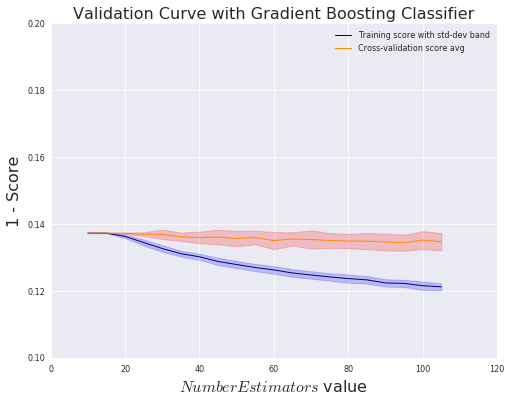

In [156]:
fig, ax = plt.subplots(figsize=(8, 6)) 

fontdict_tit = {'fontsize':16,
           'fontweight':20}

fontdict_lab = fontdict_tit
fontdict_lab['fontsize'] = 13 

plt.title("Validation Curve with Gradient Boosting Classifier",
         fontdict = fontdict)
plt.xlabel("$Number Estimators$ value".format(),
          fontdict = fontdict)
plt.ylabel("1 - Score",
          fontdict = fontdict)
plt.ylim(0.1, 0.2)

lw = 1

plt.plot(param_range, train_scores_mean, label="Training score with std-dev band",
             color="navy", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="blue", lw=lw)

plt.plot(param_range, cv_scores_mean, label="Cross-validation score avg",
             color="darkorange", lw=lw)

plt.fill_between(param_range, cv_scores_mean - cv_scores_std,
                 cv_scores_mean + cv_scores_std, alpha=0.2,
                 color="red", lw=lw)

plt.legend(loc="best")


# Todo

* xgboost
* libffm
